# Import Image Data

In [ ]:
# Note: After you run this cell, the training and test data will be available in
# the file browser. (Click the folder icon on the left to view it)
#
# If you don't see the data after the cell completes, click the refresh button
# in the file browser (folder icon with circular arrow)

# First, let's download and unzip the data
!echo "Downloading files..."
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/training1.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/training2.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/test.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/test_partial.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/test_classes_partial.csv

!echo "Unzipping files..."
!unzip -q /content/training1.zip
!unzip -q /content/training2.zip
!unzip -q /content/test.zip
!unzip -q /content/test_partial.zip

# Combine the two traning directories
!echo "Merging training data..."
!mkdir /content/training
!mv /content/training1/* /content/training
!mv /content/training2/* /content/training

# Cleanup
!echo "Cleaning up..."
!rmdir /content/training1
!rmdir /content/training2
!rm training1.zip
!rm training2.zip
!rm test.zip
!rm test_partial.zip

!echo "Data ready."

Unzipping files...
Merging training data...
Cleaning up...
Data ready.


In [ ]:
!pip install --upgrade coremltools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 23.0 MB/s eta 0:00:00


In [ ]:
# Import libraries
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import coremltools as ct

from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Process Image Data

Remember to export the model with Apple's MLKit

In [ ]:
# Set up the correct directories for getting data
training_dir = '/content/training/'
testing_dir = '/content/'
image_size = (100, 100)

# Create generators for the training and validation datasets
training_datagen   = ImageDataGenerator(rescale=1./255, validation_split=.2)
validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=.2)
testing_datagen    = ImageDataGenerator(rescale=1./255)

train_generator = training_datagen.flow_from_directory(
        training_dir,
        target_size = image_size,
        subset="training",
        batch_size=32,
        class_mode='sparse',
        seed=42,shuffle=True)

validation_generator = validation_datagen.flow_from_directory(
        training_dir,
        target_size=image_size,
        batch_size=32,
        class_mode='sparse',
        subset="validation",
        seed=42)

test_generator = testing_datagen.flow_from_directory(
    testing_dir,
    classes = ['test'],
    target_size = image_size,
    class_mode = 'sparse',
    shuffle = False)

Found 31368 images belonging to 43 classes.
Found 7841 images belonging to 43 classes.
Found 12630 images belonging to 1 classes.


# Train the model

In [ ]:
# Build the model shape
model = keras.models.Sequential()

# Convolutional Layers
model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)))
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Conv2D(256, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2))) # < --- Get rid if bad
model.add(keras.layers.Conv2D(512, (3, 3), activation='relu')) # <--- Get rid if bad
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Conv2D(128, (3, 3), activation='relu'))

# Dense Layers
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(64, activation='relu'))
#model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(43))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 256)       147712    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 256)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 21, 21, 512)       1

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_generator, validation_data=validation_generator, epochs = 7)

Epoch 1/7
981/981 [==============================] - 60s 50ms/step - loss: 0.9923 - accuracy: 0.7230 - val_loss: 0.5548 - val_accuracy: 0.8517
Epoch 2/7
981/981 [==============================] - 50s 51ms/step - loss: 0.1004 - accuracy: 0.9719 - val_loss: 0.3367 - val_accuracy: 0.9221
Epoch 3/7
981/981 [==============================] - 53s 54ms/step - loss: 0.0514 - accuracy: 0.9862 - val_loss: 0.2811 - val_accuracy: 0.9348
Epoch 4/7
981/981 [==============================] - 50s 51ms/step - loss: 0.0363 - accuracy: 0.9894 - val_loss: 0.2671 - val_accuracy: 0.9365
Epoch 5/7
981/981 [==============================] - 50s 51ms/step - loss: 0.0444 - accuracy: 0.9878 - val_loss: 0.3129 - val_accuracy: 0.9279
Epoch 6/7
981/981 [==============================] - 50s 50ms/step - loss: 0.0229 - accuracy: 0.9929 - val_loss: 0.3380 - val_accuracy: 0.9431
Epoch 7/7
981/981 [==============================] - 50s 51ms/step - loss: 0.0242 - accuracy: 0.9925 - val_loss: 0.3853 - val_accuracy: 0.9282

# Metrics

In [ ]:
probabilities = model.predict(test_generator)
test_predictions = [np.argmax(probas) for probas in probabilities]

395/395 [==============================] - 10s 26ms/step


395/395 - 10s - loss: 45.0618 - accuracy: 0.0045 - 10s/epoch - 24ms/step
45.061832427978516 0.004513063933700323


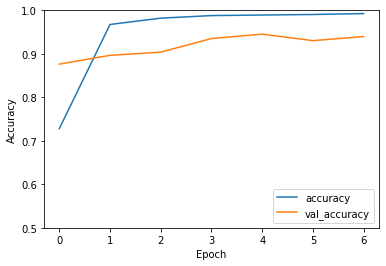

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print(test_loss,test_acc)

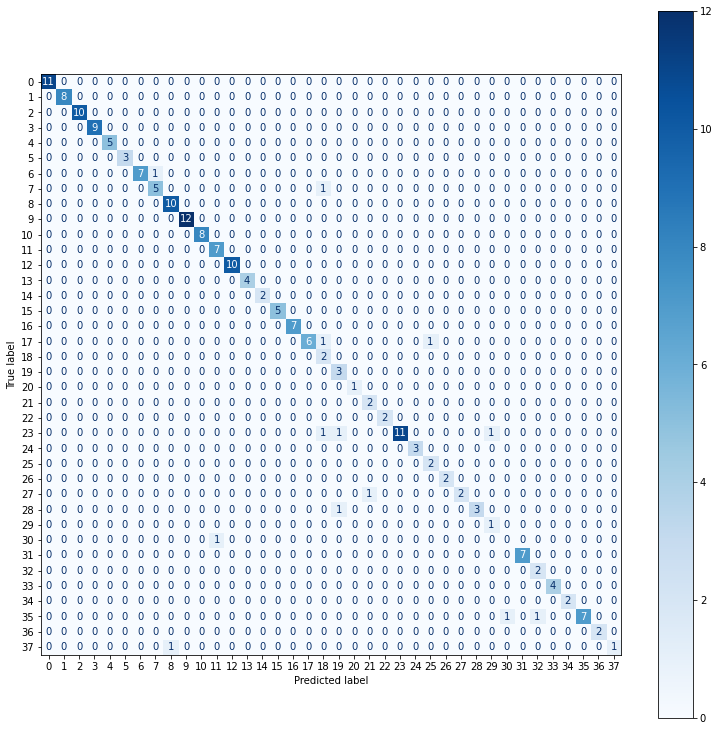

In [ ]:
y_pred = pd.read_csv("test_classes_partial.csv")
y_pred = y_pred.drop(columns = 'Filename')

cm = confusion_matrix(y_pred, test_predictions)
cmd = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(13, 13))
cmd.plot(ax=ax, cmap = "Blues", values_format = '.5g')

In [ ]:
# Save the model
print(classification_report(y_pred, test_predictions))

model.save('Model')

NameError: ignored

In [ ]:
# Convert the model to an apple version
apple_model = ct.convert(model)

print(f'Previous: {type(model)}')
print(f'New:      {type(apple_model)}')

apple_model.save('Apple')

Translating MIL ==> NeuralNetwork Ops: 100%|██████████| 76/76 [00:00<00:00, 340.70 ops/s]


Previous: <class 'keras.engine.sequential.Sequential'>
New:      <class 'coremltools.models.model.MLModel'>
